# Weather & Timing Feature Analysis

## Import

In [2]:
import pandas as pd
import os
import cv2
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
import seaborn as sb

## Set Config

In [3]:
CONFIG = {
    'data_path' : '../data/split_video.result',
    'csv_path' : '../data',
    'csv_name' : 'split_video.csv',
}

## Read CSV

In [4]:
csv_path = os.path.join(CONFIG['csv_path'], CONFIG['csv_name'])
data_frame = pd.read_csv(csv_path)
data_frame['image_path'] = [os.path.join(CONFIG['data_path'], image_name) for image_name in data_frame['image_name'].values]
data_frame_sorted = data_frame[data_frame['crash']>0]
data_frame_sorted.head()

,image_name,sample_id,label,frame_idx,crash,ego_involve,weather,timing,image_path
0,TRAIN_0000_7-0_1_0_0_0.jpg,TRAIN_0000,7,0,1,0,0,0,../data/split_video.result/TRAIN_0000_7-0_1_0_...
1,TRAIN_0000_7-1_1_0_0_0.jpg,TRAIN_0000,7,1,1,0,0,0,../data/split_video.result/TRAIN_0000_7-1_1_0_...
2,TRAIN_0000_7-2_1_0_0_0.jpg,TRAIN_0000,7,2,1,0,0,0,../data/split_video.result/TRAIN_0000_7-2_1_0_...
3,TRAIN_0000_7-3_1_0_0_0.jpg,TRAIN_0000,7,3,1,0,0,0,../data/split_video.result/TRAIN_0000_7-3_1_0_...
4,TRAIN_0000_7-4_1_0_0_0.jpg,TRAIN_0000,7,4,1,0,0,0,../data/split_video.result/TRAIN_0000_7-4_1_0_...


## Extract Feature

In [5]:
def get_feature(image:np.ndarray):
    image_gray:np.ndarray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return{
        'mean' : np.mean(image_gray),
        'median' : np.median(image_gray),
        'max' : np.max(image_gray),
        'min' : np.min(image_gray),
        'std' : np.std(image_gray),
    }

def processing(data:np.ndarray):
    image_name = data[0]
    weather = data[6]
    timing = data[7]
    image_path = data[8]
    image = cv2.imread(image_path)
    feature = get_feature(image)
    feature['image_name'] = image_name
    feature['timing'] = timing
    feature['weather'] = weather
    return feature

data = data_frame_sorted.values[0]
feature = processing(data=data)
print(feature)

{'mean': 101.29211046006944, 'median': 89.0, 'max': 255, 'min': 4, 'std': 52.771067103656634, 'image_name': 'TRAIN_0000_7-0_1_0_0_0.jpg', 'timing': 0, 'weather': 0}


In [6]:
pool = Pool(4)
features = pool.map(processing, tqdm(iter(data_frame_sorted.values)))

45750it [03:35, 212.22it/s]


In [7]:
df_features = pd.DataFrame(features)
df_features.head()

,mean,median,max,min,std,image_name,timing,weather
0,101.292110,89.0,255,4,52.771067,TRAIN_0000_7-0_1_0_0_0.jpg,0,0
1,101.305199,89.0,255,4,52.810792,TRAIN_0000_7-1_1_0_0_0.jpg,0,0
2,101.149987,89.0,255,4,52.787304,TRAIN_0000_7-2_1_0_0_0.jpg,0,0
3,101.054778,89.0,255,4,53.200631,TRAIN_0000_7-3_1_0_0_0.jpg,0,0
4,101.503177,89.0,255,5,53.237997,TRAIN_0000_7-4_1_0_0_0.jpg,0,0


## Visualize

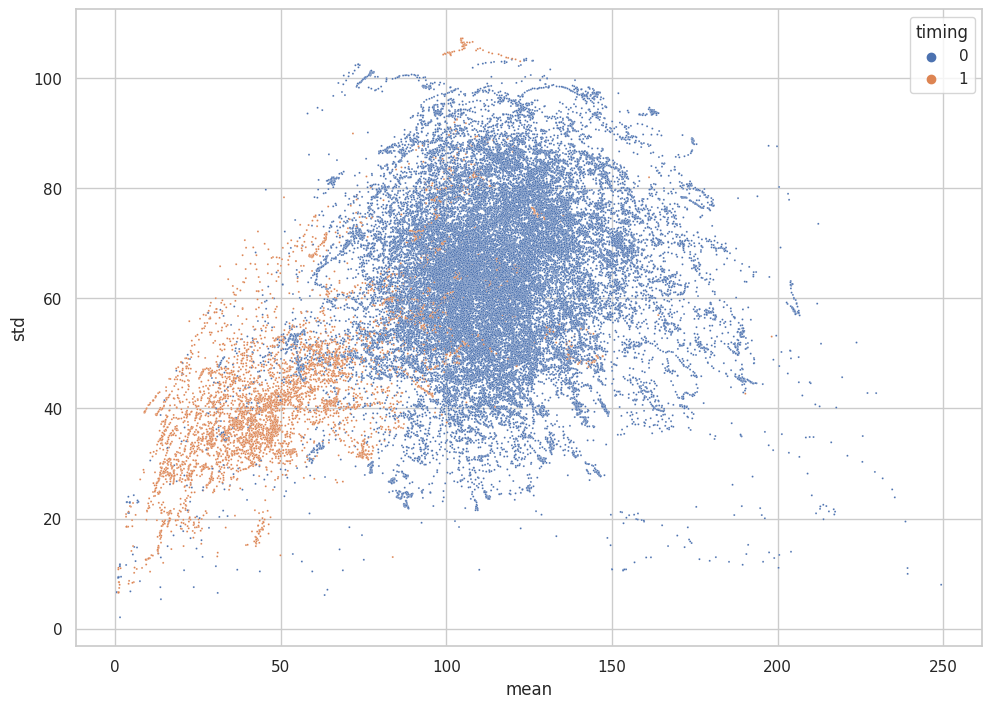

In [20]:
sb.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
ax = sb.scatterplot(x='mean', y='std', data=df_features, hue='timing', s=2, alpha=1, palette="deep")

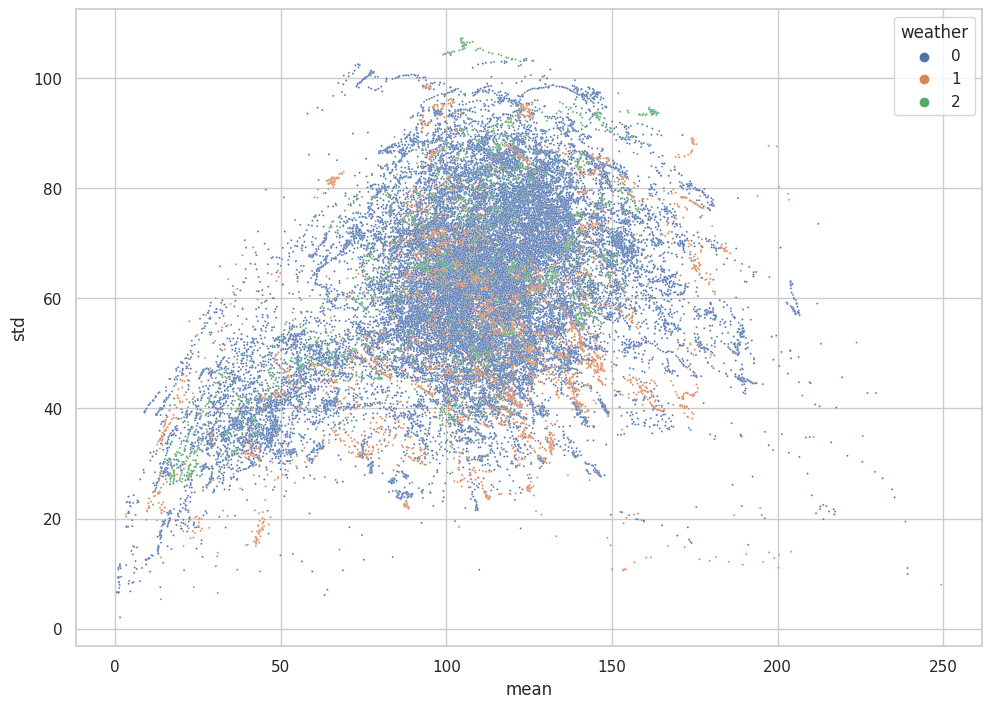

In [21]:
sb.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
ax = sb.scatterplot(x='mean', y='std', data=df_features, hue='weather', s=2, alpha=1, palette="deep")

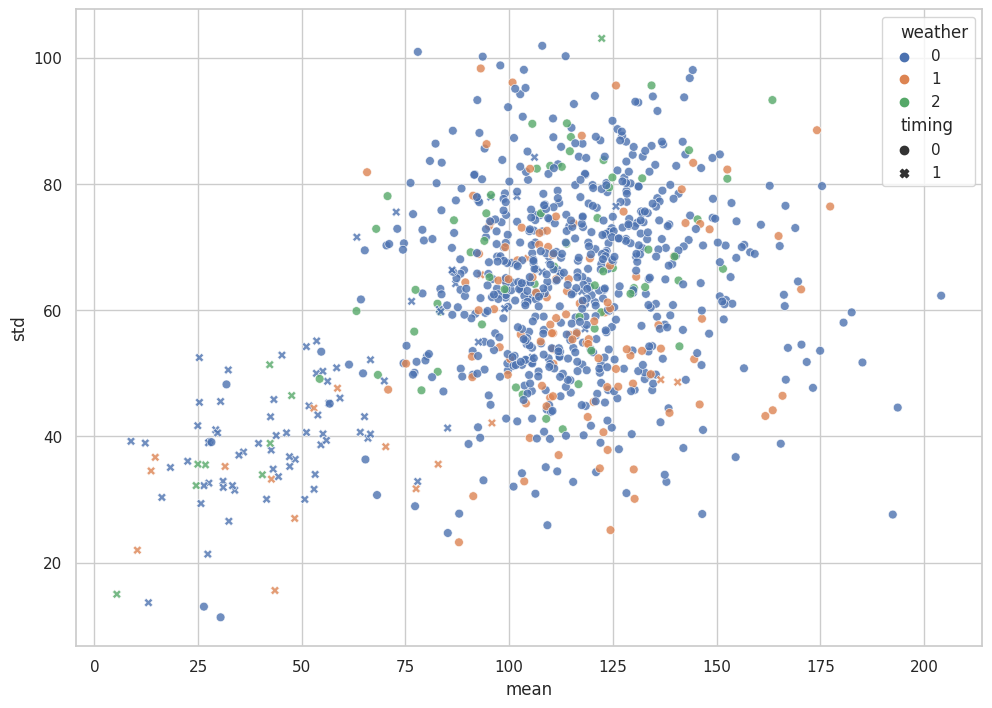

In [37]:
df_features_selected= df_features[df_features.index % 50 == 0]

sb.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
ax = sb.scatterplot(x='mean', y='std', data=df_features_selected, hue='weather', style='timing',
s=40, alpha=0.8, palette="deep")

In [44]:
for i in range(6):
    _df_selected = df_features_selected[df_features_selected['weather_by_time']==i]
    print(f'{i} : {len(_df_selected.values)}')

0 : 635
1 : 112
2 : 61
3 : 81
4 : 17
5 : 9


/tmp/ipykernel_28313/2153024357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_selected['weather_by_time'] = [ weather + 3*(timing) for weather, timing in zip(df_features_selected['weather'].values, df_features_selected['timing'].values)]


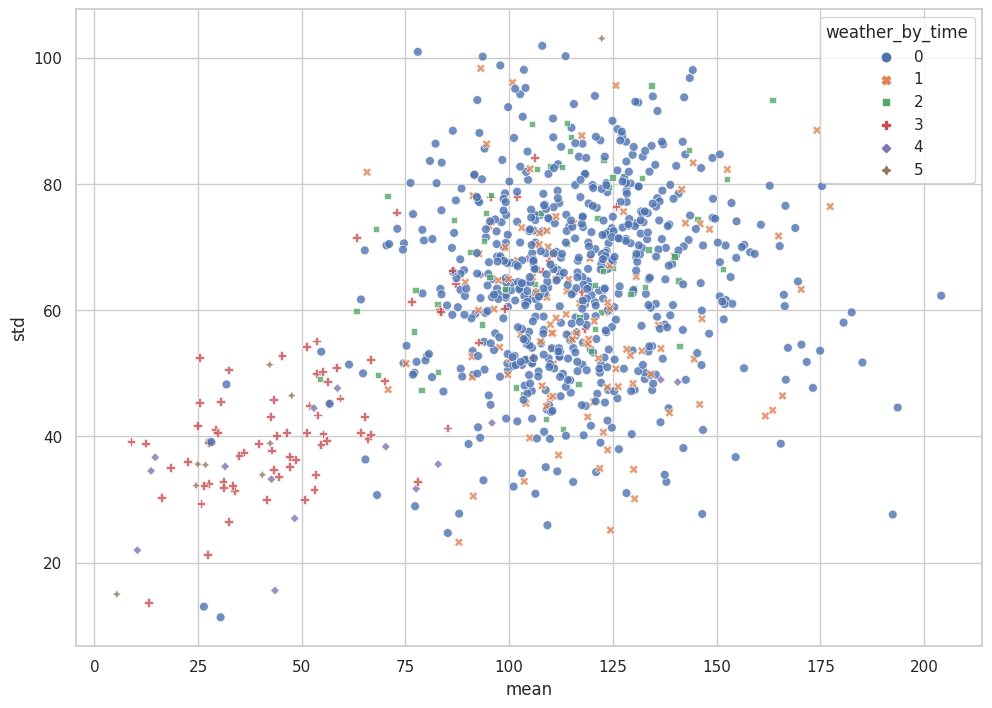

In [42]:
df_features_selected['weather_by_time'] = [ weather + 3*(timing) for weather, timing in zip(df_features_selected['weather'].values, df_features_selected['timing'].values)]
sb.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
ax = sb.scatterplot(x='mean', y='std', data=df_features_selected, hue='weather_by_time', style='weather_by_time',
s=40, alpha=0.8, palette="deep")